## Import tools

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

## Get the data

In [3]:
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
data = pd.read_csv("iris.csv", skiprows=1, header=None, names=col_names)
data.head(10)

,sepal_length,sepal_width,petal_length,petal_width,type
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


In [4]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1,1)
print(X.shape, y.shape)

(150, 4) (150, 1)


In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Visualization

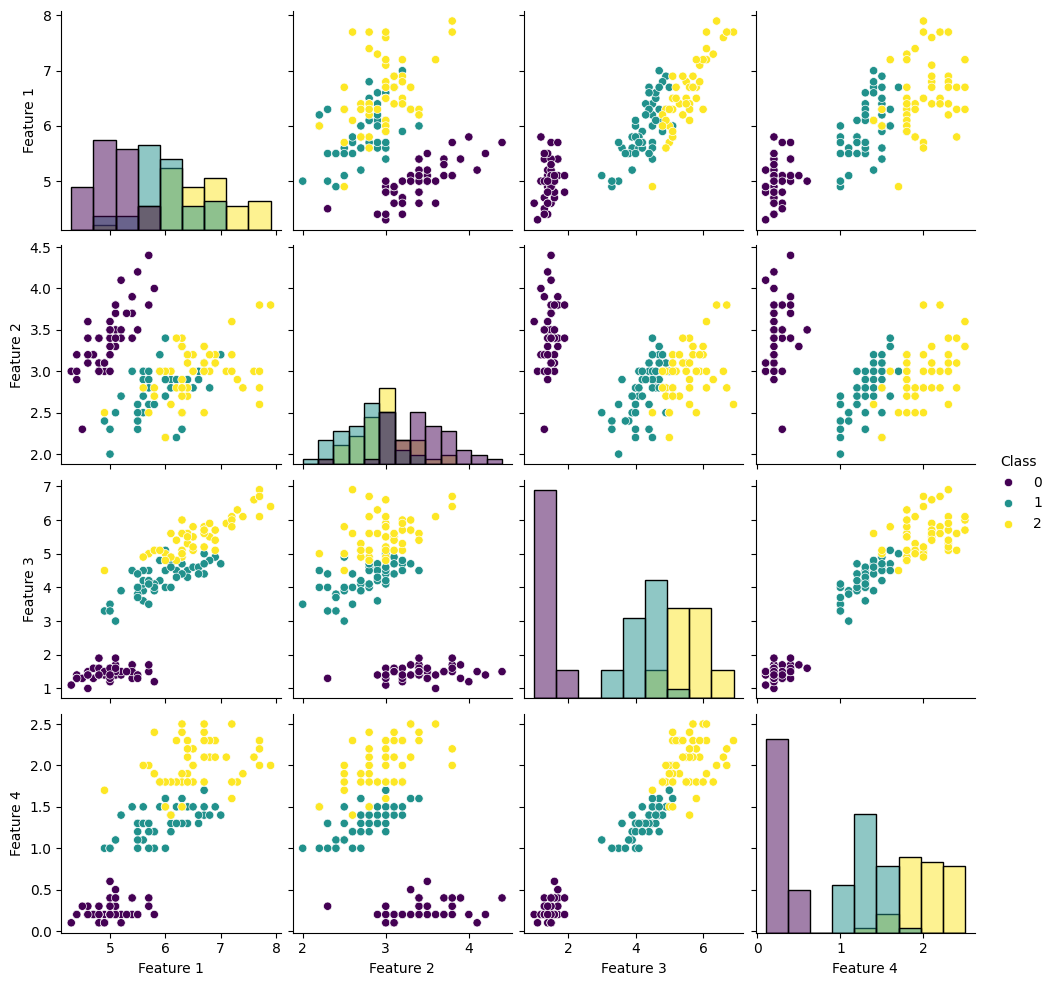

In [6]:
import seaborn as sns

def pair_plot(X, y):
    df = pd.DataFrame(X, columns=["Feature 1", "Feature 2", "Feature 3", "Feature 4"])
    df['Class'] = y
    sns.pairplot(df, hue='Class', palette='viridis', diag_kind='hist', height=2.5)
    plt.show()

# Plot the pair plot
pair_plot(X, y)


## Entropy

In [10]:
import numpy as np

def entropy(y):
    """Calculate entropy of a target variable"""
    unique_labels, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

## Information Gain

In [11]:
import numpy as np

def information_gain(X, y, feature_idx, threshold):
    """Calculate information gain given a feature and threshold"""
    total_entropy = entropy(y)

    left_indices = X[:, feature_idx] <= threshold
    right_indices = X[:, feature_idx] > threshold

    left_entropy = entropy(y[left_indices])
    right_entropy = entropy(y[right_indices])
    total_samples = len(y)
    left_weight = np.sum(left_indices) / total_samples
    right_weight = np.sum(right_indices) / total_samples
    weighted_entropy = left_weight * left_entropy + right_weight * right_entropy

    information_gain = total_entropy - weighted_entropy

    return information_gain


## Best Split

In [12]:
import numpy as np

def find_best_split(X, y):
    """Find the best split point for a dataset"""
    best_information_gain = -float("inf")
    best_feature_idx = None
    best_threshold = None

    total_entropy = entropy(y)

    for feature_idx in range(X.shape[1]):
        unique_values = np.unique(X[:, feature_idx])

        for threshold in unique_values:
            current_information_gain = information_gain(X, y, feature_idx, threshold)

            if current_information_gain > best_information_gain:
                best_information_gain = current_information_gain
                best_feature_idx = feature_idx
                best_threshold = threshold

    return best_feature_idx, best_threshold, best_information_gain


## Partition And Majority Vote

In [13]:
def partition(X, y, feature_idx, threshold):
    """Partition the dataset into left and right branches based on a split"""
    left_indices = X[:, feature_idx] <= threshold
    right_indices = ~left_indices
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]
    return X_left, y_left, X_right, y_right


def majority_vote(y):
    """Return the majority class label"""
    classes, counts = np.unique(y, return_counts=True)
    majority_class = classes[np.argmax(counts)]
    return majority_class

## Build Tree

In [17]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index  # Index of the feature to split on
        self.threshold = threshold          # Threshold value for the split
        self.left = left                    # Left subtree
        self.right = right                  # Right subtree
        self.value = value                  # Value (class label) for leaf nodes


In [18]:
def build_tree(X, y, max_depth=None, min_samples_split=2):
    """Build a decision tree recursively"""
    if len(np.unique(y)) == 1 or (max_depth is not None and max_depth == 0) or len(y) < min_samples_split:
        return Node(value=majority_vote(y))

    best_feature_idx, best_threshold, _ = find_best_split(X, y)

    if best_feature_idx is None:
        return Node(value=majority_vote(y))

    X_left, y_left, X_right, y_right = partition(X, y, best_feature_idx, best_threshold)

    left_subtree = build_tree(X_left, y_left, max_depth - 1 if max_depth is not None else None, min_samples_split)
    right_subtree = build_tree(X_right, y_right, max_depth - 1 if max_depth is not None else None, min_samples_split)

    return Node(feature_index=best_feature_idx, threshold=best_threshold, left=left_subtree, right=right_subtree)


## Prediction

In [24]:
def predict(tree, x):
    """Make predictions using the decision tree"""
    if tree.value is not None:
        return tree.value

    if x[tree.feature_index] <= tree.threshold:
        return predict(tree.left, x)
    else:
        return predict(tree.right, x)


## Main

In [27]:
# Build the decision tree model
tree = build_tree(X_train, y_train)

# Make predictions on the test set
y_pred = [predict(tree, x) for x in X_test]

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

accuracy_percentage = accuracy * 100
print("Accuracy:", accuracy_percentage, "%")

Accuracy: 100.0 %
